In [1]:
import hiive.mdptoolbox as mdptoolbox
import hiive.mdptoolbox.example
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from IPython.display import clear_output, display

# suppress pandas warning
pd.options.mode.chained_assignment = None

# set seed
np.random.seed(0)

%matplotlib inline

In [2]:
# code based on:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def get_score(env, policy, printInfo=False, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                # print('You have got the Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif done and reward == 0:
                # print("You fell in a hole!")
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100

    if (printInfo):
        print('----------------------------------------------')
        print('You took an average of {:.0f} steps to get the frisbee'.format(ave_steps))
        print('And you fell in the hole {:.2f} % of the times'.format(pct_fail))
        print('----------------------------------------------')

    return ave_steps, std_steps, pct_fail

In [3]:
colors = {
    0: 'g',
    1: 'k'
}

labels = {
    0: 'W',
    1: 'C',
}

def plot_forest(policy, title='Forest Management'):
    rows = 8
    cols = 8

    # reshape policy array to be 2-D - assumes 500 states...
    policy = np.array(list(policy)).reshape(rows,cols)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, xlim=(-.01, cols+0.01), ylim = (-.01, rows+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)

    for i in range(8):
        for j in range(8):
            y = 25 - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[policy[i,j]])
            ax.add_patch(p)

            text = ax.text(x+0.5, y+0.5, labels[policy[i, j]],
                           horizontalalignment='center', size=10, verticalalignment='center', color='w')

    plt.axis('off')
    plt.savefig('./forest/' + title + '.png', dpi=400)


#plot_forest(bestPolicy)

## Setup problem (64)

In [4]:
T,R = hiive.mdptoolbox.example.forest(S=64, r1=100, r2= 15, p=0.01)

## VI

In [5]:
def valueIteration(t, r, gammas, epsilons, showResults=False, max_iterations=100000):
    t0 = time.time()

    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)

    print('Gamma,\tEps,\tTime,\tIter,\tReward')
    print(80*'_')

    testNum = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)

            runs  = test.run()
            Time  = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR  = runs[-1]['Max V']

            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])

            policy = np.array(test.policy)

            data['gamma'][testNum]        = g
            data['epsilon'][testNum]      = e
            data['time'][testNum]         = Time
            data['iterations'][testNum]   = iters
            data['reward'][testNum]       = maxR
            data['mean_rewards'][testNum] = {tuple(mean_rewards)}
            data['max_rewards'][testNum]  = {tuple(max_rewards)}
            data['error'][testNum]        = {tuple(errors)}
            data['policy'][testNum]       = {test.policy}

            print('%.2f,\t%.0E,\t%.2f,\t%d,\t%f' % (g, e, Time, iters, maxR))

            testNum = testNum + 1

    endTime = time.time() - t0
    print('Time taken: %.2f' % endTime)

    # See differences in policy
    policies = data['policy']

    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()

    return data

In [6]:
gammas   = [0.5, 0.75, 0.9, 0.95, 0.99, 0.9999]
epsilons = [1e-3, 1e-6, 1e-9, 1e-12, 1e-15]
vi_data  = valueIteration(T, R, gammas, epsilons, showResults=False)

#vi_data.head()

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.50,	1E-03,	0.00,	17,	198.025084
0.50,	1E-06,	0.00,	27,	198.026357
0.50,	1E-09,	0.00,	37,	198.026358
0.50,	1E-12,	0.00,	46,	198.026358
0.50,	1E-15,	0.00,	56,	198.026358
0.75,	1E-03,	0.00,	43,	388.398086
0.75,	1E-06,	0.00,	66,	388.399158
0.75,	1E-09,	0.00,	89,	388.399159
0.75,	1E-12,	0.00,	112,	388.399159
0.75,	1E-15,	0.00,	136,	388.399159
0.90,	1E-03,	0.00,	119,	917.819231
0.90,	1E-06,	0.00,	179,	917.820239
0.90,	1E-09,	0.00,	239,	917.820240
0.90,	1E-12,	0.01,	299,	917.820240
0.90,	1E-15,	0.01,	348,	917.820240
0.95,	1E-03,	0.00,	69,	1657.673686
0.95,	1E-06,	0.00,	69,	1657.673686
0.95,	1E-09,	0.00,	69,	1657.673686
0.95,	1E-12,	0.01,	574,	1687.368663
0.95,	1E-15,	0.01,	687,	1687.368663
0.99,	1E-03,	0.00,	65,	3670.193595
0.99,	1E-06,	0.00,	65,	3670.193595
0.99,	1E-09,	0.00,	65,	3670.193595
0.99,	1E-12,	0.03,	1833,	6427.347126
0.99,	1E-15,	0.04,	2177,	6427.347177
1.00,	1E-03,	0.

In [7]:
policies = vi_data['policy']

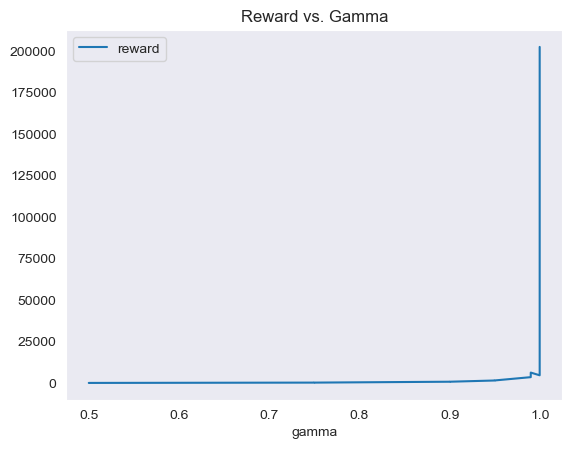

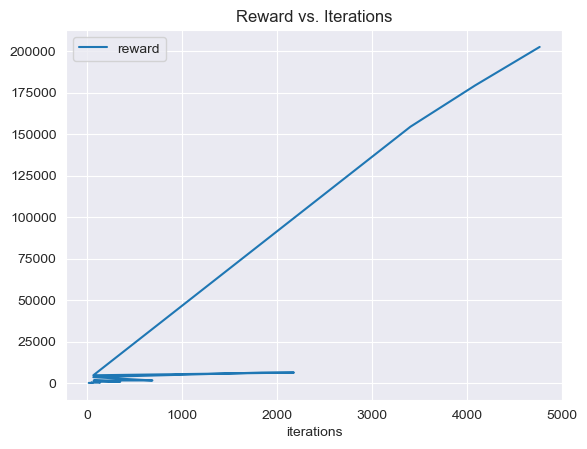

In [8]:
vi_data.plot(x='gamma', y='reward', title="Reward vs. Gamma")
plt.grid()

vi_data.plot(x='iterations', y='reward', title="Reward vs. Iterations")
plt.grid(True)

Best Result:
	Reward = 202561.75
	Gamma = 0.9999000
	Epsilon= 1E-15


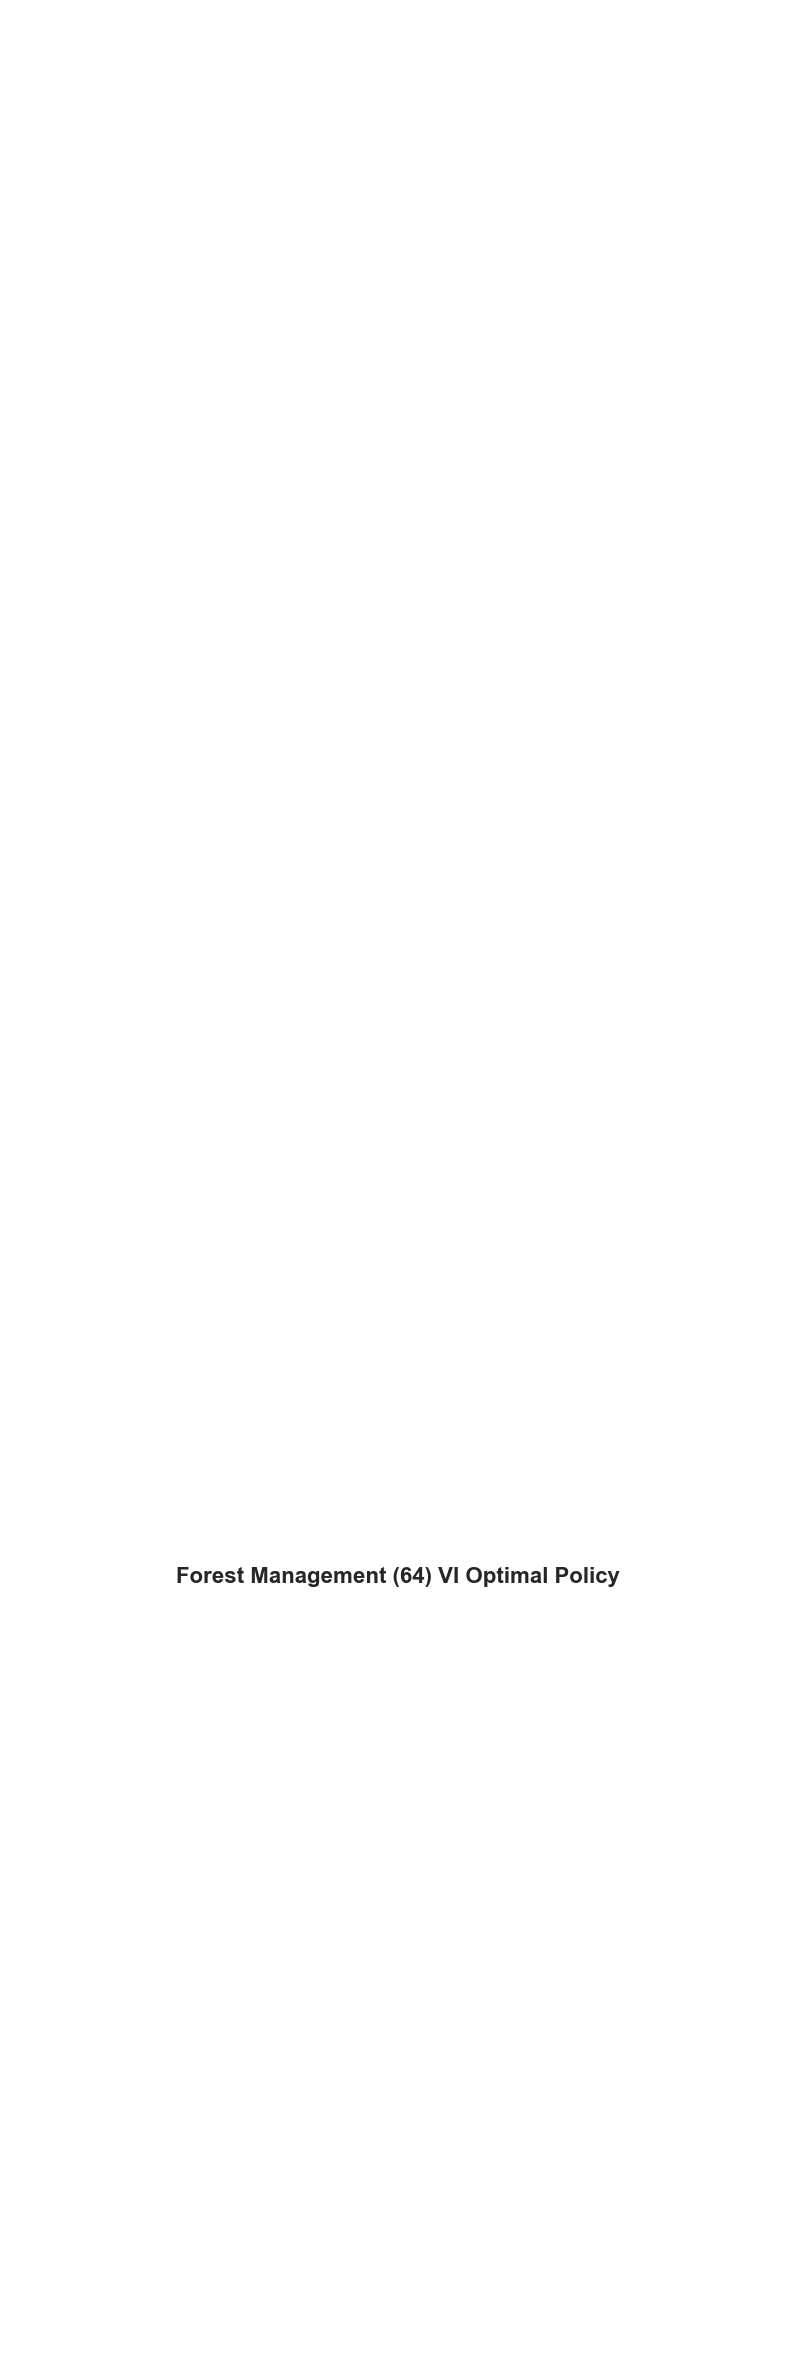

In [9]:
# find the highest score
bestRun = vi_data['reward'].argmax()
bestPolicy = vi_data['policy'][bestRun]

title='Forest Management (64) VI Optimal Policy'
plot_forest(bestPolicy, title)

# Save off data to a csv file
vi_data.to_csv('forest/64_VI_results.csv')

print('Best Result:\n\tReward = %.2f\n\tGamma = %.7f\n\tEpsilon= %.E' % (vi_data['reward'].max(), vi_data['gamma'][bestRun], vi_data['epsilon'][bestRun]))

## PI

In [10]:
def policyIteration(t, r, gammas, showResults=False, max_iterations=100000):
    t0 = time.time()

    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=columns)

    print('gamma,\ttime,\titer,\treward')
    print(80*'_')

    testnum = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="matrix") # eval_type="iterative"

        runs  = test.run()
        Time  = test.time
        iters = test.iter
        maxr  = runs[-1]['Max V']

        max_rewards, mean_rewards, errors = [], [], []
        for run in runs:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
            errors.append(run['Error'])

        data['gamma'][testnum]        = g
        data['time'][testnum]         = Time
        data['iterations'][testnum]   = iters
        data['reward'][testnum]       = maxr
        data['mean_rewards'][testnum] = {tuple(mean_rewards)}
        data['max_rewards'][testnum]  = {tuple(max_rewards)}
        data['error'][testnum]        = {tuple(errors)}
        data['policy'][testnum]       = {test.policy}

        print('%.2f,\t%.2f,\t%d,\t%f' % (g, Time, iters, maxr))

        testnum = testnum + 1

    endTime = time.time() - t0
    print('Time taken: %.2f' % endTime)

    # see differences in policy
    policies = data['policy']

    # replace all nan's
    data.fillna(0, inplace=True)
    data.head()

    return data

In [11]:
gammas   = [0.5, 0.75, 0.9, 0.95, 0.99, 0.9999]
pi_data  = policyIteration(T, R, gammas, showResults=False)

#pi_data.head()

gamma,	time,	iter,	reward
________________________________________________________________________________
0.50,	0.69,	8,	198.026358
0.75,	0.11,	18,	388.399159
0.90,	0.34,	46,	917.820240
0.95,	0.45,	63,	1682.219951
0.99,	0.03,	63,	5049.750013
1.00,	0.03,	63,	14827.336274
Time taken: 1.69


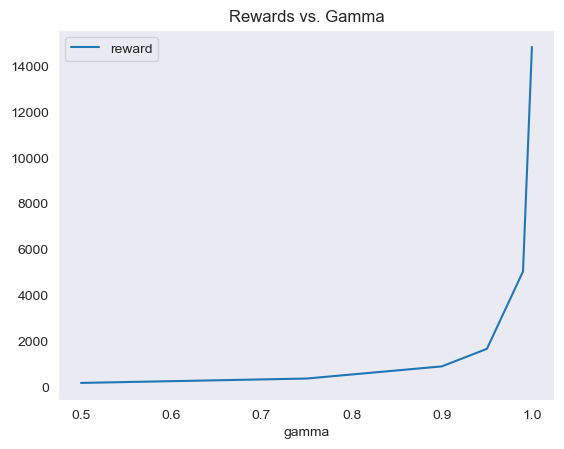

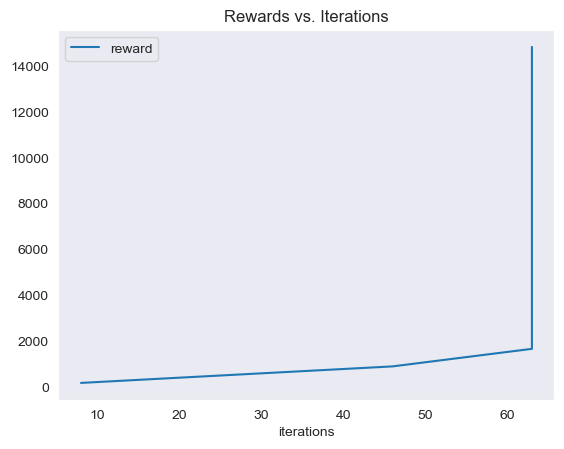

In [12]:
pi_data.plot(x='gamma', y='reward', title='Rewards vs. Gamma')
plt.grid()

pi_data.plot(x='iterations', y='reward', title='Rewards vs. Iterations')
plt.grid()

Best Result:
	Reward = 14827.34
	Gamma = 1.000


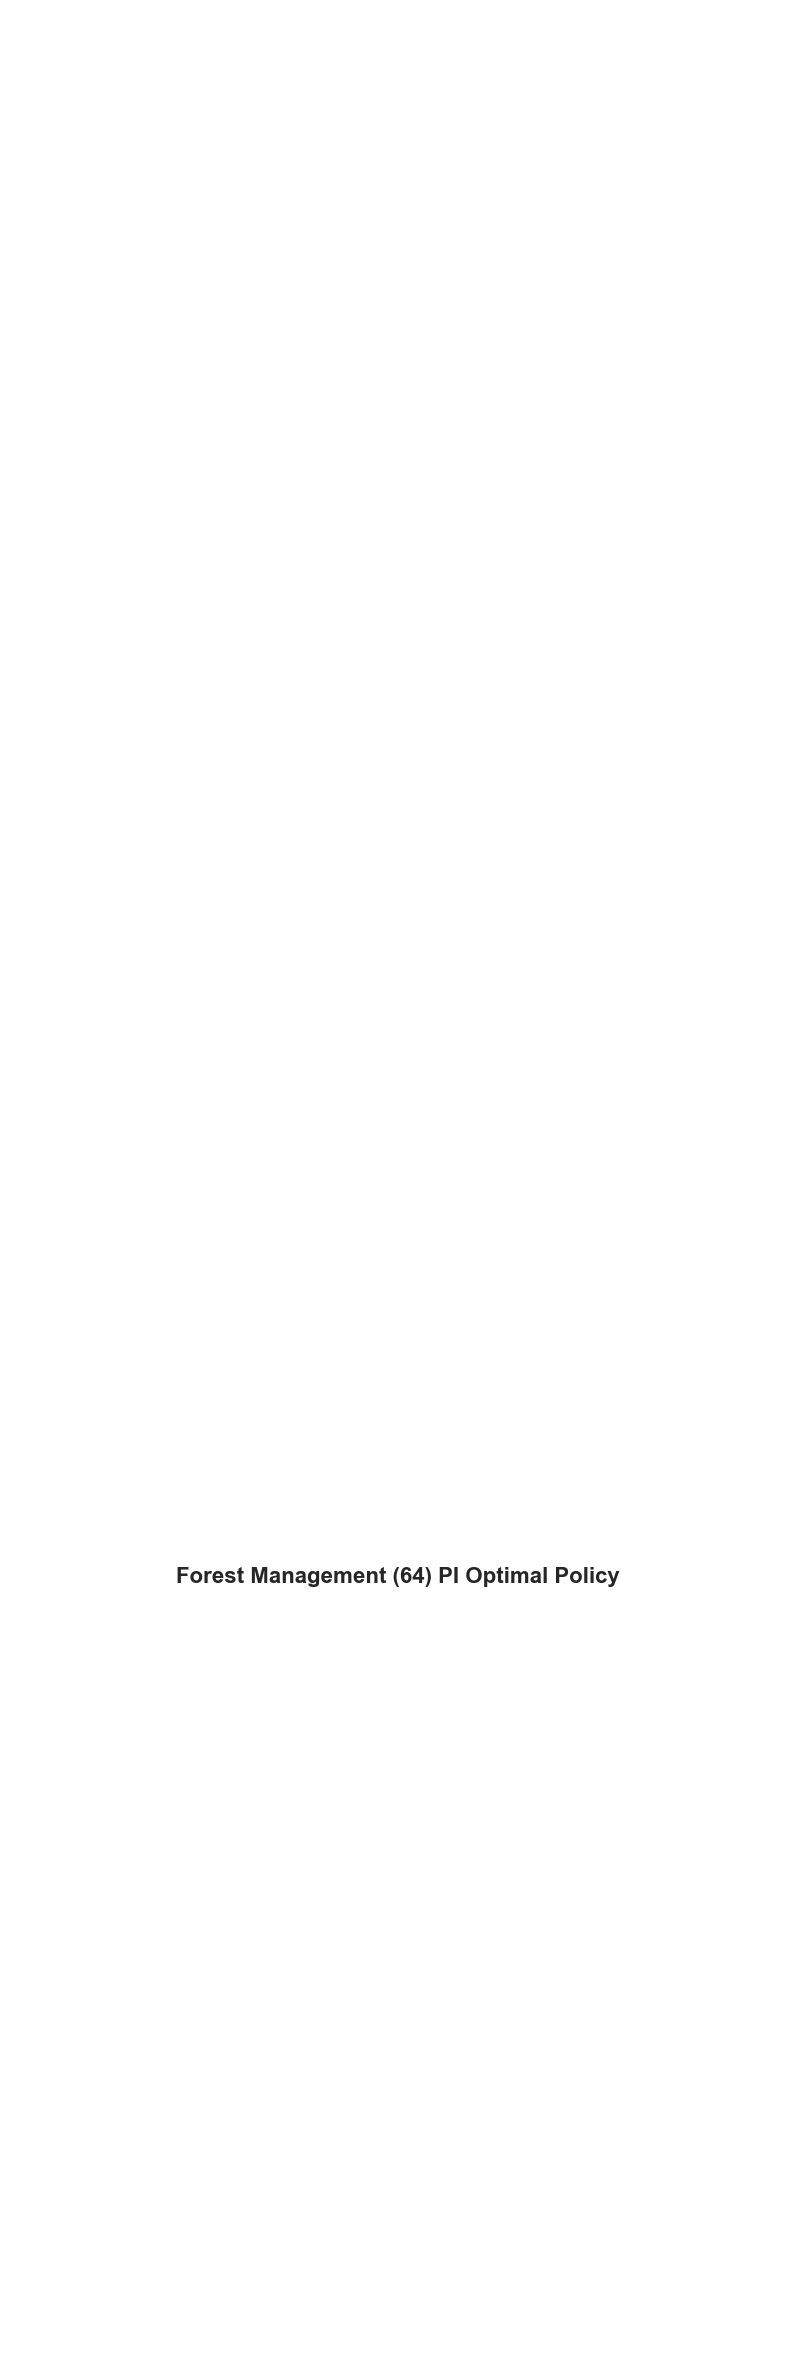

In [13]:
# find the highest score
bestRun = pi_data['reward'].argmax()
bestPolicy = pi_data['policy'][bestRun]

title='Forest Management (64) PI Optimal Policy'
plot_forest(bestPolicy, title)

# Save off data to a csv file
pi_data.to_csv('forest/64_PI_results.csv')

print('Best Result:\n\tReward = %.2f\n\tGamma = %.3f' % (pi_data['reward'].max(), pi_data['gamma'][bestRun]))


## Q-Learning

In [14]:
def qLearning(t, r, gammas, alphas, alpha_decays=[0.9], epsilon_decays=[0.99], n_iterations=[1e5], showResults=False):
    # create data structure to save off
    columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    numTests = len(gammas)*len(alphas)*len(alpha_decays)*len(epsilon_decays)*len(n_iterations)
    data = pd.DataFrame(0.0, index=np.arange(numTests), columns=columns)

    print('Gamma,\tAlpha,\tTime,\tIter,\tReward')
    print(80*'_')

    testNum = 0
    for g in gammas:
        for a in alphas:
            for a_decay in alpha_decays:
                for e_decay in epsilon_decays:
                    for n in n_iterations:
                        print('Test Num %d/%d' %(testNum+1, numTests))
                        print('Gamma: %.2f,\tAlpha: %.2f,\tAlpha Decay:%.3f,\tEpsilon Decay:%.3f,\tIterations:%d'
                             %(g, a, a_decay, e_decay, n))

                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)

                        runs  = test.run()
                        time  = runs[-1]['Time']
                        iters = runs[-1]['Iteration']
                        maxR  = runs[-1]['Max V']

                        max_rewards, mean_rewards, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            mean_rewards.append(run['Mean V'])
                            errors.append(run['Error'])

                        #policy = np.array(test.policy)
                        #policy = policy.reshape(4,4)

                        data['gamma'][testNum]         = g
                        data['alpha'][testNum]         = a
                        data['alpha_decay'][testNum]   = a_decay
                        data['epsilon_decay'][testNum] = e_decay
                        data['time'][testNum]          = time
                        data['iterations'][testNum]    = iters
                        data['reward'][testNum]        = maxR
                        data['mean_rewards'][testNum]  = {tuple(mean_rewards)}
                        data['max_rewards'][testNum]   = {tuple(max_rewards)}
                        data['error'][testNum]         = {tuple(errors)}
                        data['policy'][testNum]        = {test.policy}

                        print('%.2f,\t%.2f,\t%.2f,\t%d,\t%f' % (g, a, time, iters, maxR))

                        if showResults:
                            pass

                        testNum = testNum + 1

    # See differences in policy
    policies = data['policy']

    '''
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures
    '''

    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()

    return data

In [15]:
gammas         = [0.8, 0.9, 0.99]
alphas         = [0.01, 0.1, 0.2]
alpha_decays   = [0.9, 0.999]
epsilon_decays = [0.9, 0.999]
iterations     = [1e4, 1e5, 1e6]


ql_data  = qLearning(T, R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=False)

# write all results to csv file
csvFile = 'forest/64_QL_results.csv'
ql_data.to_csv(csvFile)

ql_data.head()


Gamma,	Alpha,	Time,	Iter,	Reward
________________________________________________________________________________
Test Num 1/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:10000
0.80,	0.01,	0.15,	10000,	5.865910
Test Num 2/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:100000
0.80,	0.01,	1.25,	100000,	62.940726
Test Num 3/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:1000000
0.80,	0.01,	11.96,	1000000,	336.837904
Test Num 4/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:10000
0.80,	0.01,	0.14,	10000,	11.174371
Test Num 5/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:100000
0.80,	0.01,	1.23,	100000,	68.502317
Test Num 6/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:1000000
0.80,	0.01,	11.87,	1000000,	314.390761
Test Num 7/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay

,gamma,alpha,alpha_decay,epsilon_decay,iterations,time,reward,average_steps,steps_stddev,success_pct,policy,mean_rewards,max_rewards,error
0,0.8,0.01,0.9,0.900,10000.0,0.150975,5.865910,0.0,0.0,0.0,"{(0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,...","{(0.0, 0.00014062500000000002, 0.0001406250000...","{(0.0, 0.009000000000000001, 0.009000000000000...","{(0.0, 0.009000000000000001, 0.0, 0.0, 0.0, 0...."
1,0.8,0.01,0.9,0.900,100000.0,1.245683,62.940726,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,...","{(0.00031978585296385303, 0.000457076106361682...","{(0.01, 0.015255719999495187, 0.02038185589680...","{(0.003874300950566592, 1.6342697072476483e-05..."
2,0.8,0.01,0.9,0.900,1000000.0,11.958517,336.837904,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,...","{(0.0011468500301354745, 0.014120449539464352,...","{(0.06179274498246584, 0.7994402239440089, 0.7...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.09910394867180015..."
3,0.8,0.01,0.9,0.999,10000.0,0.141347,11.174371,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,...","{(0.0, 0.00014062500000000002, 0.0001406250000...","{(0.0, 0.009000000000000001, 0.009000000000000...","{(0.0, 0.009000000000000001, 0.0, 0.0, 0.0, 0...."
4,0.8,0.01,0.9,0.999,100000.0,1.229005,68.502317,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,...","{(0.0003457812358217098, 0.0004738377974427959...","{(0.01, 0.012322396404418356, 0.01537561456072...","{(2.2460945464882683e-05, 0.001336115580935473..."


In [16]:
# Read in Q-Learning data
ql_data = pd.read_csv('forest/64_QL_results.csv')
ql_data.head()

,Unnamed: 0,gamma,alpha,alpha_decay,epsilon_decay,iterations,time,reward,average_steps,steps_stddev,success_pct,policy,mean_rewards,max_rewards,error
0,0,0.8,0.01,0.9,0.900,10000.0,0.150975,5.865910,0.0,0.0,0.0,"{(0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,...","{(0.0, 0.00014062500000000002, 0.0001406250000...","{(0.0, 0.009000000000000001, 0.009000000000000...","{(0.0, 0.009000000000000001, 0.0, 0.0, 0.0, 0...."
1,1,0.8,0.01,0.9,0.900,100000.0,1.245683,62.940726,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,...","{(0.00031978585296385303, 0.000457076106361682...","{(0.01, 0.015255719999495187, 0.02038185589680...","{(0.003874300950566592, 1.6342697072476483e-05..."
2,2,0.8,0.01,0.9,0.900,1000000.0,11.958517,336.837904,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,...","{(0.0011468500301354745, 0.014120449539464352,...","{(0.06179274498246584, 0.7994402239440089, 0.7...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.09910394867180015..."
3,3,0.8,0.01,0.9,0.999,10000.0,0.141347,11.174371,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,...","{(0.0, 0.00014062500000000002, 0.0001406250000...","{(0.0, 0.009000000000000001, 0.009000000000000...","{(0.0, 0.009000000000000001, 0.0, 0.0, 0.0, 0...."
4,4,0.8,0.01,0.9,0.999,100000.0,1.229005,68.502317,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,...","{(0.0003457812358217098, 0.0004738377974427959...","{(0.01, 0.012322396404418356, 0.01537561456072...","{(2.2460945464882683e-05, 0.001336115580935473..."


In [17]:
# Look at correlation matrix
interest = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'reward', 'time']

# pick out hyperparameters and how succesful they were
df = ql_data[interest]

# See what affected the success_pct the most
ql_corr = df.corr()

/var/folders/yq/rrz1xzpj60j7kl2lvygmc3800000gn/T/ipykernel_93932/4269853779.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(ql_corr, dtype=np.bool))


<AxesSubplot:title={'center':'Correlation Matrix of Q-Learning Parameters'}>

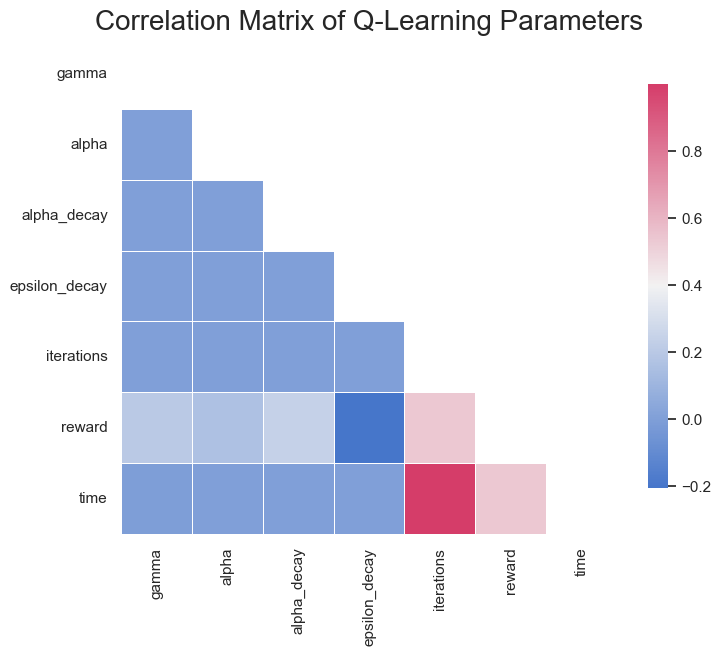

In [18]:
# Create heatmap of correlation matrix
sns.set(style="white")
fig, ax = plt.subplots(figsize=(8,7))
ax.set_title('Correlation Matrix of Q-Learning Parameters', fontsize=20)
mask = np.triu(np.ones_like(ql_corr, dtype=np.bool))
cmap = sns.diverging_palette(255, 0, as_cmap=True)
sns.heatmap(ql_corr, mask=mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink":.75})

In [19]:
def plot_QL(dependent, independent, title=None, logscale=False):
    if dependent not in interest:
        print('Dependent variable not available')
        return
    if independent not in interest:
        print('Independent variable not available')
        return

    x = np.unique(df[dependent])
    y = []

    for i in x:
        y.append(df.loc[df[dependent] == i][independent].mean())

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, y, 'o-')

    if title == None:
        title = independent + ' vs. ' + dependent
    plt.title(title, fontsize=15)
    plt.xlabel(dependent)
    plt.ylabel(independent)
    plt.grid(True)
    if logscale:
        plt.xscale('log')

    title='64 QL_' + independent + '_vs_' + dependent
    plt.savefig('./forest/' + title + '.png', dpi=400)

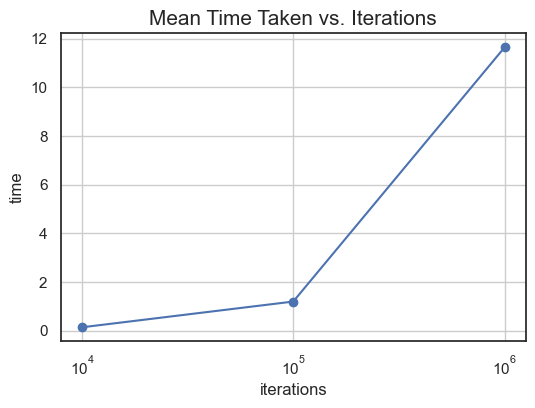

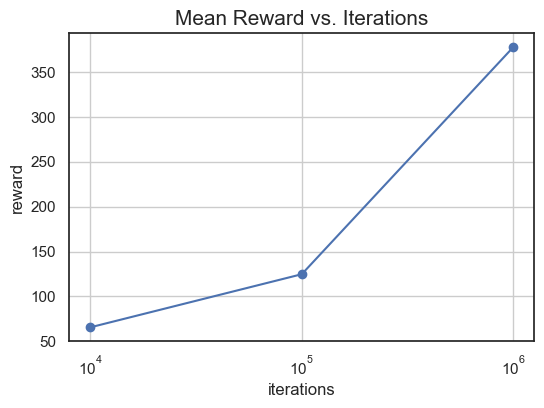

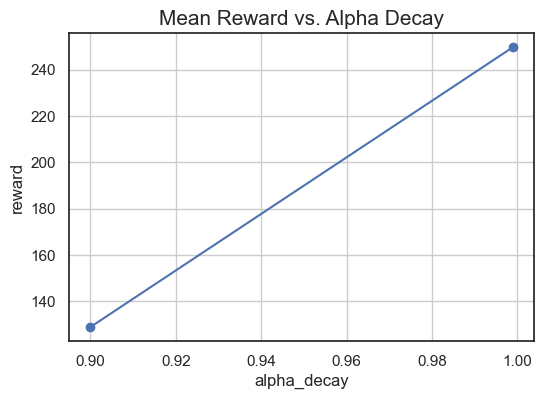

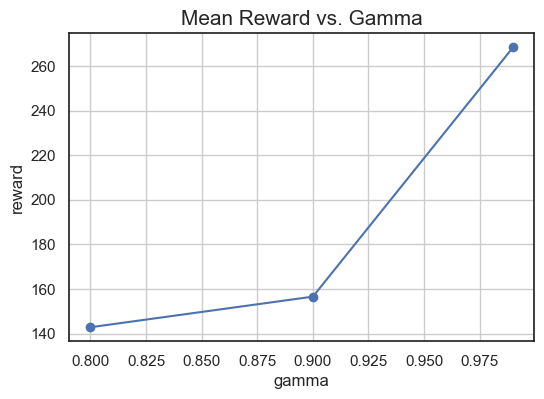

In [20]:
# Plot time vs. Iterations
plot_QL('iterations', 'time', title='Mean Time Taken vs. Iterations', logscale=True)

plot_QL('iterations', 'reward', title='Mean Reward vs. Iterations', logscale=True)

# Plot alpha decay vs success pct
plot_QL('alpha_decay', 'reward', title='Mean Reward vs. Alpha Decay')

# Plot results vs. gamma
plot_QL('gamma', 'reward', title='Mean Reward vs. Gamma')

Best Result:
	Reward = 1342.89
	Gamma = 0.99,
	Alpha = 0.10,
	Alpha Decay: 0.999,
	Epsilon Decay: 0.900,
	Iterations: 1.0E+06


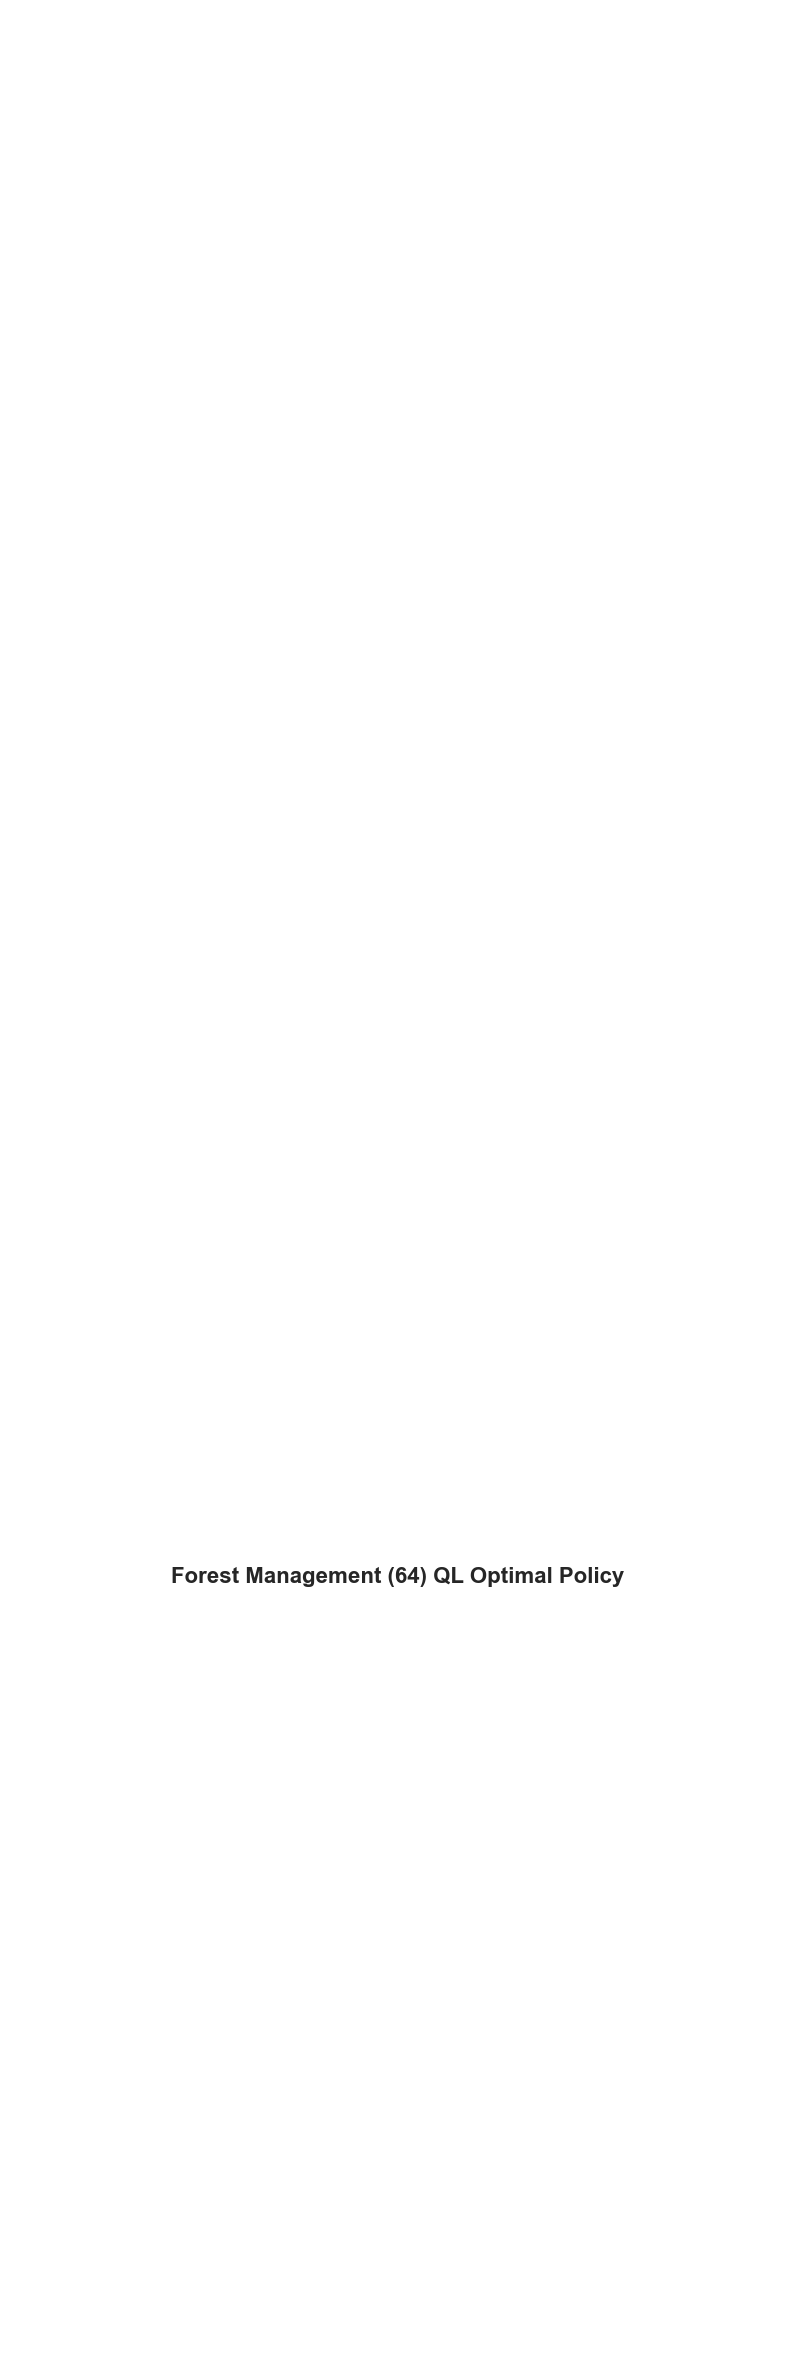

In [22]:
# Plot most successful gamma

# find the score with the highest success percentage and get its policy
bestRun = ql_data['reward'].argmax()

best_policy = ql_data['policy'][bestRun]

# reshape the policy since we pulled from a csv file
best_policy = best_policy[1:-1]
best_policy = eval(best_policy)
best_policy = np.array(best_policy)
best_policy = best_policy.reshape(8, 8)

# plot the policy
title='Forest Management (64) QL Optimal Policy'
plot_forest(best_policy, title)

print('Best Result:\n\tReward = %.2f\n\tGamma = %.2f,\n\tAlpha = %.2f,\n\tAlpha Decay: %.3f,\n\tEpsilon Decay: %.3f,\n\tIterations: %.1E'
      % (ql_data['reward'].max(), ql_data['gamma'][bestRun], ql_data['alpha'][bestRun], ql_data['alpha_decay'][bestRun], ql_data['epsilon_decay'][bestRun], ql_data['iterations'][bestRun]))